In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sb

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Lecture 14: Feature engineering and feature selection 

UBC 2025

Instructor: Andrew Roth

### Announcements 
- Final exam dates and registration posted. See Piazza.
- MT1 marked. Viewing in CBTF bookings open. See Piazza.
- HW5 is due March 10th (start now!)

## Learning outcomes 

From this lecture, students are expected to be able to:

- Explain what feature engineering is and the importance of feature engineering in building machine learning models.  - Carry out preliminary feature engineering on numeric and text data. 
- Explain the general concept of feature selection. 
- Discuss and compare different feature selection methods at a high level. 
- Use `sklearn`'s implementation of model-based selection and recursive feature elimination (`RFE`)

## Feature engineering: Motivation

### iClicker Exercise 14.1 

**iClicker cloud join link: https://join.iclicker.com/HTRZ**

**Select the most accurate option below.**

Suppose you are working on a machine learning project. If you have to prioritize one of the following in your project which of the following would it be? 

- (A) The quality and size of the data 
- (B) Most recent deep neural network model 
- (C) Most recent optimization algorithm
- (D) Domain expertise

**Discussion question**
- Suppose we want to predict whether a flight will arrive on time or be delayed. We have a dataset with the following information about flights:
    - Departure Time
    - Expected Duration of Flight (in minutes)

Upon analyzing the data, you notice a pattern: flights tend to be delayed more often during the evening rush hours. What feature could be valuable to add for this prediction task?
<br><br><br><br>

### Garbage in, garbage out.

- Model building is interesting. But in your machine learning projects, you'll be spending more than half of your time on data preparation, feature engineering, and transformations.
- The _quality_ of the data is important. Your model is only as good as your data. 

### What is feature engineering?  

- Better features: more flexibility, higher score, we can get by with simple and more interpretable models. 
- If your features, i.e., representation is bad, whatever fancier model you build is not going to help.

<blockquote>
<b>Feature engineering</b> is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.<br> 
- Jason Brownlee    
</blockquote>    

### Some quotes on feature engineering 

A quote by Pedro Domingos [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

<blockquote>
... At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. 
</blockquote>


A quote by Andrew Ng, [Machine Learning and AI via Brain simulations](https://ai.stanford.edu/~ang/slides/DeepLearning-Mar2013.pptx)

<blockquote>
Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.
</blockquote>

### Better features usually help more than a better model.
- Good features would ideally:
    - Capture most important aspects of the problem
    - Allow learning with few examples 
    - Generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With simple features overfitting risk is low, but scores might be low.
    - With complicated features scores can be high, but so is overfitting risk.

- The best features may be dependent on the model you use

### The best features may be dependent on the model you use.

- Examples:
    - For counting-based methods like decision trees separate relevant groups of variable values
        - Discretization makes sense 
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods like linear regression, we want targets to have a linear dependency on features.

#### Domain-specific transformations

In some domains there are natural transformations to do:
- Spectrograms (sound data)
- Wavelets (image data)
- Convolutions 
- Read counts (genomics)


![](../img/spectogram.png)

[Source](https://en.wikipedia.org/wiki/Spectrogram)

### Domain-specific transformations (Genomics)

![](../img/genomics_snv_counts.png)


#### Domain-specific transformations (Genomics)

- [Unsupervised ML with simple features](https://academic.oup.com/bioinformatics/article/28/7/907/209164)

- [Supervised ML with complicated features](https://academic.oup.com/bioinformatics/article/28/2/167/197256)

### Feature interactions and feature crosses

- A **feature cross** is a synthetic feature formed by multiplying or crossing two or more features. 
- Example: 
Is the following dataset (XOR function) linearly separable?  

In [3]:
X = np.array([
    [-1, -1],
    [1, -1],
    [-1, 1],
    [1, 1]
])
y = np.array([1, 0, 0, 1])
df = pd.DataFrame(np.column_stack([X, y]), columns=["X1", "X2", "target"])

In [4]:
df

,X1,X2,target
0,-1,-1,1
1,1,-1,0
2,-1,1,0
3,1,1,1


<Axes: xlabel='X1', ylabel='X2'>

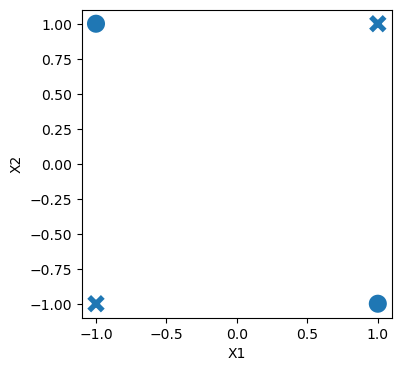

In [5]:
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X1", y="X2", style="target", s=200, legend=False)

- For XOR like problems, if we create a feature cross $x1x2$, the data becomes linearly separable.

In [6]:
df["X1X2"] = df["X1"] * df["X2"]
df

,X1,X2,target,X1X2
0,-1,-1,1,1
1,1,-1,0,-1
2,-1,1,0,-1
3,1,1,1,1


<Axes: xlabel='X2', ylabel='X1X2'>

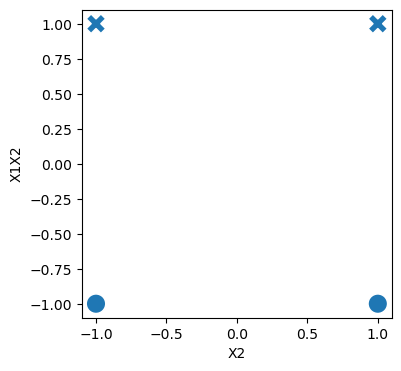

In [7]:
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X2", y="X1X2", style="target", s=200, legend=False)

Let's look at an example with more data points.

In [8]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
df = pd.DataFrame(
    np.column_stack([X, y]), columns=["X1", "X2", "target"]
)

<Axes: xlabel='X1', ylabel='X2'>

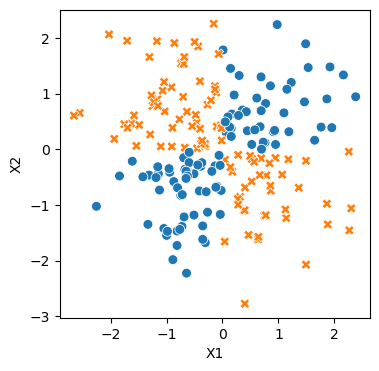

In [9]:
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X1", y="X2", hue="target", style="target", s=50, legend=False)

In [10]:
LogisticRegression().fit(X, y).score(X, y)

0.535

In [11]:
from sklearn.preprocessing import PolynomialFeatures

pipe_xor = make_pipeline(
    PolynomialFeatures(interaction_only=True, include_bias=False), LogisticRegression()
)

pipe_xor.fit(X, y).score(X, y)

0.995

In [12]:
# Create an interactive 3D scatter plot using plotly
# import plotly.express as px
# df["X1_X2"] = df["X1"] * df["X2"]
# fig = px.scatter_3d(df, x="X1", y="X2", z="X1_X2", color="target", color_continuous_scale=['blue', 'red'])
# fig.show();

In [13]:
feature_names = (
    pipe_xor.named_steps["polynomialfeatures"].get_feature_names_out().tolist()
)
pd.DataFrame(
    pipe_xor.named_steps["logisticregression"].coef_.transpose(),
    index=feature_names,
    columns=["Feature coefficient"],
)

,Feature coefficient
x0,-0.028672
x1,0.129459
x0 x1,-5.086461


The interaction feature has the biggest coefficient! 

### Feature crosses for one-hot encoded features
- You can think of feature crosses of one-hot-features as logical conjunctions
- Suppose you want to predict whether you will find parking or not based on two features: 
    - area (possible categories: UBC campus and Rogers Arena)
    - time of the day (possible categories: 9am and 7pm)
- A feature cross in this case would create four new features: 
    - UBC campus and 9am
    - UBC campus and 7pm
    - Rogers Arena and 9am
    - Rogers Arena and 7pm. 
- The features UBC campus and 9am on their own are not that informative but the newly created feature UBC campus and 9am or Rogers Arena and 7pm would be quite informative.

- Coming up with the right combination of features requires some domain knowledge or careful examination of the data. 
- There is no easy way to support feature crosses in sklearn. 

### Demo of feature engineering with numeric features

- Remember the [California housing dataset](https://www.kaggle.com/datasets/camnugent/california-housing-prices) we used earlier in the course? 
- The prediction task is predicting `median_house_value` for a given community. 

In [14]:
housing_df = pd.read_csv("../data/california_housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Suppose we decide to train `ridge` model on this dataset. 

- What would happen if you train a model without applying any transformation on the categorical features ocean_proximity? 
    - Error!! A linear model requires all features in a numeric form.  
- What would happen if we apply OHE on `ocean_proximity` but we do not scale the features?
    - No syntax error. But the model results are likely to be poor. 
- Do we need to apply any other transformations on this data?     

In this section, we will look into some common ways to do feature engineering for numeric or categorical features.  

In [16]:
train_df, test_df = train_test_split(housing_df, test_size=0.2, random_state=123)

We have total rooms and the number of households in the neighbourhood. How about creating rooms_per_household feature using this information? 

In [17]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

In [18]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,287500.0,INLAND,6.219512
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,271500.0,<1H OCEAN,5.951644
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,191700.0,<1H OCEAN,3.628032
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,219700.0,<1H OCEAN,5.126238
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,114000.0,<1H OCEAN,4.024390


Let's start simple. Imagine that we only three features: `longitude`, `latitude`, and our newly created `rooms_per_household` feature. 

In [19]:
X_train_housing = train_df[["latitude", "longitude", "rooms_per_household"]]
y_train_housing = train_df["median_house_value"]

In [20]:
from sklearn.compose import make_column_transformer

numeric_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor1 = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats)
)

In [21]:
lr_1 = make_pipeline(preprocessor1, Ridge())
pd.DataFrame(
    cross_validate(lr_1, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.010576,0.002686,0.280028,0.311769
1,0.003821,0.002123,0.325319,0.300464
2,0.005086,0.001786,0.317277,0.301952
3,0.005165,0.002631,0.316798,0.303004
4,0.141181,0.001688,0.260258,0.314840


- The scores are not great. 
- Let's look at the distribution of the longitude and latitude features. 

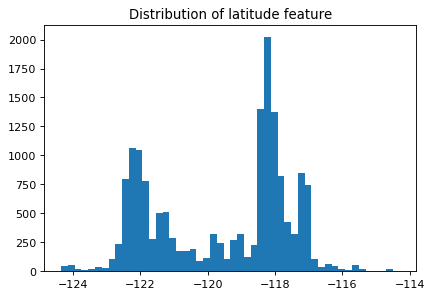

In [22]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["longitude"], bins=50)
plt.title("Distribution of latitude feature");

- Suppose you are planning to build a linear model for housing price prediction. 
- If we think longitude is a good feature for prediction, does it makes sense to use the floating point representation of this feature that's given to us?
- Remember that linear models can capture only linear relationships. 

- How about discretizing latitude and longitude features and putting them into buckets?
- This process of transforming numeric features into categorical features is called bucketing or binning. 
- In `sklearn` you can do this using `KBinsDiscretizer` transformer. 
- Let's examine whether we get better results with binning.

In [23]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude"]
numeric_feats = ["rooms_per_household"]

preprocessor2 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats),
)

In [24]:
lr_2 = make_pipeline(preprocessor2, Ridge())
pd.DataFrame(
    cross_validate(lr_2, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.020515,0.006860,0.441445,0.456419
1,0.033412,0.005285,0.469571,0.446216
2,0.018376,0.004822,0.479132,0.446869
3,0.023001,0.005977,0.450822,0.453367
4,0.020815,0.005439,0.388169,0.467628


The results are better with binned features. Let's examine the binned features. 

In [25]:
pd.DataFrame(
    preprocessor2.fit_transform(X_train_housing).todense(),
    columns=preprocessor2.get_feature_names_out(),
)

,kbinsdiscretizer__latitude_0.0,kbinsdiscretizer__latitude_1.0,kbinsdiscretizer__latitude_2.0,kbinsdiscretizer__latitude_3.0,kbinsdiscretizer__latitude_4.0,kbinsdiscretizer__latitude_5.0,kbinsdiscretizer__latitude_6.0,kbinsdiscretizer__latitude_7.0,kbinsdiscretizer__latitude_8.0,kbinsdiscretizer__latitude_9.0,...,kbinsdiscretizer__longitude_11.0,kbinsdiscretizer__longitude_12.0,kbinsdiscretizer__longitude_13.0,kbinsdiscretizer__longitude_14.0,kbinsdiscretizer__longitude_15.0,kbinsdiscretizer__longitude_16.0,kbinsdiscretizer__longitude_17.0,kbinsdiscretizer__longitude_18.0,kbinsdiscretizer__longitude_19.0,pipeline__rooms_per_household
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316164
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209903
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711852
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.117528
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.554621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.064307
16508,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.235706
16509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212581
16510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.271037


How about discretizing all three features? 

In [26]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor3 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
)

In [27]:
lr_3 = make_pipeline(preprocessor3, Ridge())
pd.DataFrame(
    cross_validate(lr_3, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.052440,0.005039,0.590618,0.571969
1,0.024833,0.005097,0.575907,0.570473
2,0.018898,0.004511,0.579091,0.573542
3,0.021608,0.004053,0.571500,0.574260
4,0.025827,0.005010,0.541488,0.581687


- The results have improved further!! 
- Let's examine the coefficients

In [28]:
lr_3.fit(X_train_housing, y_train_housing)
feature_names = (
    lr_3.named_steps["columntransformer"]
    .named_transformers_["kbinsdiscretizer"]
    .get_feature_names_out()
)

In [29]:
coefs_df = pd.DataFrame(
    lr_3.named_steps["ridge"].coef_.transpose(),
    index=feature_names,
    columns=["coefficient"],
).sort_values("coefficient", ascending=False)
coefs_df.head(n=10)

,coefficient
longitude_1.0,211343.036136
latitude_1.0,205059.296601
latitude_0.0,201862.534342
longitude_0.0,190319.721818
longitude_2.0,160282.191204
longitude_3.0,157234.920305
latitude_2.0,154105.963689
rooms_per_household_19.0,138503.477291
latitude_8.0,135299.516394
longitude_4.0,132292.924485


Let's focus on the rooms_per_household bins

In [30]:
room_rows = [x.startswith("rooms") for x in coefs_df.index]
coefs_df.loc[room_rows].sort_values(by="coefficient")

,coefficient
rooms_per_household_1.0,-51143.091625
rooms_per_household_0.0,-50884.444297
rooms_per_household_2.0,-47606.596151
rooms_per_household_5.0,-43445.134061
rooms_per_household_3.0,-42060.071975
rooms_per_household_4.0,-40689.197649
rooms_per_household_6.0,-32734.570739
rooms_per_household_7.0,-30573.540359
rooms_per_household_8.0,-26919.381190
rooms_per_household_9.0,-19591.810098


- Does it make sense to take feature crosses in this context?
- What information would they encode? 

### Interim summary 

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem. 

Check out [Appendix A](appendixA_feature-engineering-text-data.ipynb) for a demo of feature engineering on text data. 

- In the context of text data, if we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. 
- Some common features include:
    - ngram features
    - part-of-speech features
    - named entity features
    - emoticons in text
- These are usually extracted from pre-trained models using libraries such as `spaCy`.  
- Now a lot of this has moved to deep learning.
- But many industries still rely on manual feature engineering.

### Feature engineering 

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.
- If you have lots of data, use deep learning methods. 

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    

## Feature selection: Introduction and motivation


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 

### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at some automatic feature selection methods from `sklearn`:
    - Model-based selection 
    - Recursive feature elimination
    - Forward/backward selection 
- Very related to looking at feature importances.

In [31]:
from sklearn.datasets import load_breast_cancer

df = load_breast_cancer(as_frame=True)["frame"]
train_df, test_df = train_test_split(
    df, random_state=0, test_size=0.5
)
train_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
395,14.06,17.18,89.75,609.1,0.08045,0.05361,0.02681,0.03251,0.1641,0.05764,...,25.34,96.42,684.5,0.1066,0.1231,0.0846,0.07911,0.2523,0.06609,1
393,21.61,22.28,144.40,1407.0,0.11670,0.20870,0.28100,0.15620,0.2162,0.06606,...,28.74,172.00,2081.0,0.1502,0.5717,0.7053,0.24220,0.3828,0.10070,0
381,11.04,14.93,70.67,372.7,0.07987,0.07079,0.03546,0.02074,0.2003,0.06246,...,20.83,79.73,447.1,0.1095,0.1982,0.1553,0.06754,0.3202,0.07287,1
198,19.18,22.49,127.50,1148.0,0.08523,0.14280,0.11140,0.06772,0.1767,0.05529,...,32.06,166.40,1688.0,0.1322,0.5601,0.3865,0.17080,0.3193,0.09221,0
145,11.90,14.65,78.11,432.8,0.11520,0.12960,0.03710,0.03003,0.1995,0.07839,...,16.51,86.26,509.6,0.1424,0.2517,0.0942,0.06042,0.2727,0.10360,1


In [32]:
X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]

X_test = test_df.drop(columns=["target"])
y_test = test_df["target"]

X_train.shape

(284, 30)

In [33]:
lr_l2_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pd.DataFrame(cross_validate(lr_l2_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.003166
score_time     0.000980
test_score     0.968233
train_score    0.987681
dtype: float64

How could you use the coefficients for feature selection?

In [34]:
lr_l2_pipe.fit(X_train, y_train)
pd.Series(lr_l2_pipe.named_steps["logisticregression"].coef_[0], index=X_train.columns)

mean radius               -0.226111
mean texture              -0.549475
mean perimeter            -0.221070
mean area                 -0.292530
mean smoothness           -0.068116
mean compactness           0.197617
mean concavity            -0.648555
mean concave points       -0.851493
mean symmetry             -0.444497
mean fractal dimension     0.098324
radius error              -1.317334
texture error             -0.026222
perimeter error           -0.862855
area error                -0.749326
smoothness error           0.327195
compactness error          0.835563
concavity error            0.018267
concave points error      -0.308506
symmetry error             0.135853
fractal dimension error    0.876668
worst radius              -0.799291
worst texture             -0.682827
worst perimeter           -0.625307
worst area                -0.679874
worst smoothness          -0.386772
worst compactness         -0.047397
worst concavity           -0.858240
worst concave points      -1

### Linear models recap (Optional)

- Recall that in linear regression our predictions are given by
$$\hat{y_i} = \sum_j w_j x_{i j} + b$$

- To estimate the coefficients $w_j$, linear regression tries to minimize the following equation
$$ \sum_i |\hat{y_i} - y_i|^2$$
that is the squared error between predicted and observed values.

#### Ridge regression (L2 penalty) (Optional) 

- In this course we have said to use Ridge instead of LinearRegression to avoid overfitting the coefficients

- In Ridge regression we still predict values using $\hat{y_i} = \sum_j w_j x_{i j} + b$

- But to estimate the coefficients we **minimize** a different equation
<br>
$$ \sum_i |\hat{y_i} - y_i|^2 + \alpha \sum_j |w_j|^2 $$

- The term $\sum_j |w_j|^2$ is a penalty which discourages large coefficients.

- The strength of the penalty is controlled by $\alpha$ which we have seen can be tuned using cross-validation.

#### Lasso regression (L1 penalty) (Optional)

- We can consider other penalties instead of $\sum_j |w_j|^2$.
  - But we still predict values using $\hat{y_i} = \sum_j w_j x_{i j} + b$

- A very common choice of penalty to use the absolute value $\sum_j |w_j|$
  -  This called the L1 norm because the absolute value is to the power 1

- To estimate the coefficients we **minimize**
<br>
$$ \sum_i |\hat{y_i} - y_i|^2 + \alpha \sum_j |w_j| $$

- This is callled Lasso regression and is implemented in the `sklearn.linear_model.Lasso` class
 
- An interesting feature of using the L1 penalty is that it will often set coefficients to zero!
  - This can be considered a form of feature selection.

### Logistic regression (L1 and L2) (Optional)

- We have focused on linear regression so far, but the same ideas apply to LogisticRegression.

- The two main differences:
  1. We use a sigmoid for predicting i.e. $\hat{y_i} = \sigma(\sum_j w_j x_{i j} + b)$
  <br>
  2. We replace $|\hat{y_i} - y_i|^2$ with a different equation appropriate for classification.
 
- By default scikit-learn uses an L2 penalty for LogisticRegression.
  - You can change this using the `penalty` argument.
  - You may have to also change the `solver` argument.

### (Optional)

In [35]:
lr_l2_pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(max_iter=1000)
)
pd.DataFrame(cross_validate(lr_l2_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.002836
score_time     0.001081
test_score     0.968233
train_score    0.987681
dtype: float64

In [36]:
lr_l1_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear")
)
pd.DataFrame(cross_validate(lr_l1_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.002579
score_time     0.000823
test_score     0.971805
train_score    0.986803
dtype: float64

In [37]:
lr_l2_pipe.fit(X_train, y_train);

In [38]:
lr_l1_pipe.fit(X_train, y_train)
pd.Series(lr_l1_pipe.named_steps["logisticregression"].coef_[0], index=X_train.columns)

mean radius                0.000000
mean texture              -0.177969
mean perimeter             0.000000
mean area                  0.000000
mean smoothness            0.000000
mean compactness           0.000000
mean concavity             0.000000
mean concave points       -0.428542
mean symmetry             -0.365429
mean fractal dimension     0.000000
radius error              -2.918046
texture error              0.000000
perimeter error            0.000000
area error                 0.000000
smoothness error           0.000000
compactness error          0.604476
concavity error            0.000000
concave points error       0.000000
symmetry error             0.000000
fractal dimension error    0.772330
worst radius              -2.225703
worst texture             -1.014587
worst perimeter            0.000000
worst area                 0.000000
worst smoothness           0.000000
worst compactness          0.000000
worst concavity           -1.259636
worst concave points      -2

In [39]:
print("L1 logistic regression uses {} features".format(np.sum(lr_l1_pipe.named_steps["logisticregression"].coef_ != 0)))
print("L2 logistic regression uses {} features".format(np.sum(lr_l2_pipe.named_steps["logisticregression"].coef_ != 0)))

L1 logistic regression uses 11 features
L2 logistic regression uses 30 features


### L1 vs L2 penalty summary (Optional)

- The L1 penalty will usually set some coefficients to zero
- The L2 penalty will make coefficients smaller but rarely set them to zero
- When correlated variables are present:
  - L1 will usually keep one and set the other coefficients to zero
  - L2 will usually shrink the coefficient of all of them
- L1 and L2 penalties can be combined!
  - This is called the **elastic net** penalty and is available in sklearn.

### Model-based selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important once. 
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `RandomForestClassifier` for feature selection with threshold "median" of feature importances. 
- Approximately how many features will be selected? 

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    threshold="median"
)

We can put the feature selection transformer in a pipeline. 

In [41]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.079113
score_time     0.005969
test_score     0.950564
train_score    0.974480
dtype: float64

Note that RandomForest is doing the feature selction and LogisticRegression is doing the classification with the reduced set of features.

In [42]:
pipe_lr_model_based.fit(X_train, y_train)
pipe_lr_model_based.named_steps["selectfrommodel"].transform(X_train.values).shape

(284, 15)

- Similar results with only 15 features instead of 30 features.
- Interestingly L1 regularization does better with fewer features here but that will vary on other data.

Can we use KNN to select features?

In [43]:
select_knn = SelectFromModel(
    KNeighborsClassifier(), 
    threshold="median"
)

pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_knn, LogisticRegression(max_iter=1000)
)

# pd.DataFrame(
#    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)#
# ).mean()

**No** KNN won't work since it does not report feature importances.

What about SVC?

In [44]:
select_svc = SelectFromModel(
    SVC(), threshold="median"
)

pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_svc, LogisticRegression(max_iter=1000)
)

# pd.DataFrame(
#    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
# ).mean()

Only with a linear kernel but not with RBF kernel

### (iClicker) Exercise 14.2 

**iClicker cloud join link: https://join.iclicker.com/HTRZ**

**Select all of the following statements which are TRUE.**

- (A) L2 regularized logistic regression sets correlated coefficients to zero
- (B) Lasso regression predicts values using $\hat{y_i} = \sum_j w_j x_{i j} + b$
- (C) Lasso and Ridge regression optimize different measures of "error" between predicted and observe target values
- (D) KNN and SVM RBF can be used with SelectFromModel
- (E) I saw way to much math today!

### Recursive feature elimination (RFE)

- Build a series of models
- At each iteration, discard the least important feature according to the model. 
- Computationally expensive
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### RFE algorithm 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!

In [45]:
from sklearn.feature_selection import RFE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# create ranking of features
rfe = RFE(LogisticRegression(), n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([16, 12, 19, 13, 23, 20, 10,  1,  9, 22,  2, 25,  5,  7, 15,  4, 26,
       18, 21,  8,  1,  1,  1,  6, 14, 24,  3,  1, 17, 11])

In [46]:
print(rfe.support_)

[False False False False False False False  True False False False False
 False False False False False False False False  True  True  True False
 False False False  True False False]


In [47]:
print("selected features: ", X_train.columns[rfe.support_])

selected features:  Index(['mean concave points', 'worst radius', 'worst texture',
       'worst perimeter', 'worst concave points'],
      dtype='object')


- How do we know what value to pass to `n_features_to_select`?

- Use `RFECV` which uses cross-validation to select number of features.

For illustration purposes

In [48]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_scaled, y_train)
print(rfe_cv.support_)
print(X_train.columns[rfe_cv.support_])

[False  True False  True False False  True  True  True False  True False
  True  True False  True False False False  True  True  True  True  True
 False False  True  True False  True]
Index(['mean texture', 'mean area', 'mean concavity', 'mean concave points',
       'mean symmetry', 'radius error', 'perimeter error', 'area error',
       'compactness error', 'fractal dimension error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area', 'worst concavity',
       'worst concave points', 'worst fractal dimension'],
      dtype='object')


But we should really use pipelines

In [49]:
rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.483327
score_time     0.003362
test_score     0.943609
train_score    1.000000
dtype: float64

- Slow because there is cross validation within cross validation 
- Not a big improvement in scores compared to all features on this toy case

### (Optional) Search and score

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

### General idea of search and score methods 

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations do we have to try out? 

### (Optional) Forward or backward selection 

- Also called wrapper methods
- Shrink or grow feature set by removing or adding one feature at a time 
- Makes the decision based on whether adding/removing the feature improves the CV score or not

![](../img/forward_selection.png)

<!-- <img src='img/forward_selection.png' width="1000" height="1000" /> -->

In [50]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(LogisticRegression(max_iter=1000), 
                              direction="forward", 
                              n_features_to_select='auto', 
                              tol=None),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(
    cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
).mean()

fit_time       2.726793
score_time     0.003909
test_score     0.933020
train_score    1.000000
dtype: float64

In [51]:
pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), 
                           direction="backward", 
                           n_features_to_select=15),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(
    cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
).mean()

fit_time       3.196814
score_time     0.004300
test_score     0.950627
train_score    1.000000
dtype: float64

### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### (iClicker) Exercise 14.3 

**iClicker cloud join link: https://join.iclicker.com/HTRZ**

**Select all of the following statements which are TRUE.**

- (A) Simple association-based feature selection approaches do not take into account the interaction between features.
- (B) You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).
- (C) Forward search is guaranteed to find the best feature set.  
- (D) The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by the model.
- (E) If you remove 10 features in a single step based on feature importance, the same 10 features would be removed if we performed sequential removal calculating feature importance after removing each feature.

## (Optional) Problems with feature selection 

- The term 'relevance' is not clearly defined.
- What all things can go wrong with feature selection?
- Attribution: From CPSC 340. 

### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)

<img src='../img/sex_mom_dad.png' width="600" height="600" />

- True model: You almost have the same value as your biological mom.

### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 
    

<img src='../img/SNP.png' width="400" height="400"/>


#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<img src='../img/sex_mom_mom2_dad.png' width="600" height="600"/>


### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- Conditional independence
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<img src='../img/sex_mom_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem)
    - Features can become relevant due to missing information 


<img src='../img/sex_dad_grandma.png' width="600" height="600"/>


### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem (Confounding)
    - Hidden features can make irrelevant features relevant.

<img src='../img/sex_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem (non causality)
    - the relevant feature may not be causal 

<img src='../img/sex_dad_sibling.png' width="600" height="600"/>


### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - adding a feature can make an irrelevant feature relevant

<img src='../img/sex_dad_baby.png' width="600" height="600"/>


### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- Confounding factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

### General advice on finding relevant features

- Try forward selection. 
- Try other feature selection methods (e.g., `RFE`, simulated annealing, genetic algorithms)
- Try LASSO **(Not part of course, but useful in real life)**
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)